# Lending Club Case Study

<strong>Objectives</strong>

Using EDA, the company wants to understand the driving factors (or driver variables) behind loan default, i.e. the variables which are strong indicators of default. The company can utilise this knowledge for its portfolio and risk assessment.

<strong>How Objectives will be utilized?</strong>

When the company receives a loan application, based on above indicators, the company wants to make a decision for loan approval based on the applicant’s profile. The decision should help in not losing the business to the company if the applicant is able to pay and at the same time, do not enter in to credit loss (financial loss) to the company if the applicant is not able to pay.

<br></br>
<strong>Assumptions</strong>

1. The company allows a loan to remain delinquent for a period of time before considering it as default.

<br></br>
<strong>Decisions</strong>

1. Considering assumption 1, we are not considering the column 'mths_since_last_delinq' as part of dataset since our goal is to identify factors which can help even prior approving the loan but not after the applicant has delinquent the loan which happens once the loan is approved.

<br></br>
<strong>Approach</strong>

1. As a first step, ensure the dataset is clean. As we are not sure which parameter or variable (column) would have impact on defaulting, the approach objective is to retain clean data including whatever possible columns. <br>Here, we perform Data Cleaning Steps by following the checklist: Fix rows and columns, Missing Values, Standardise Numbers, Standardise Text, Fix Invalid Values and Filter Data
2. Once the above master dataset is created, we try to make subsets appropriately to assess the impacts of variables.

<br></br>

### Common Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

### Common Functions

In [2]:
#Check and drop column within the data frame.

def dropColumn(dataframe, colName):
    ret = dataframe
    if colName in dataframe.columns:
        ret = dataframe.drop(colName, axis=1)

    return ret

In [3]:
# printing value_counts for set of columns.

def valueCounts(df, cols=[]):
    cols = df.columns if not cols else cols
    for rec in cols:
        print("---- %s ---" % rec)
        print(df[rec].value_counts())

In [4]:
# convert str to percent

def convertToPercent(df, col):
    df[col] = df[col].str.strip('%').astype('float')

In [5]:
# print bars for given data frame and columns

def show_bars(df, cols):
    for rec in cols:
        print("---- Column: %s ---" % rec)
        fig, ax = plt.subplots()
        df[rec].value_counts().plot(ax=ax, kind='bar')

### Data Imports

In [8]:
loans_orig = pd.read_csv("/Users/ak_palakodeti/self/courses/iiit/ml_ai/assignments/02_lending_club_case_study/loan.csv")

#Copy the original data set
loans = loans_orig.copy()

print(loans.shape)

(39717, 111)


/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Data Cleaning

#### 1. Fix Rows and Columns

Handle Incorrect rows, Summary rows, Extra rows, Missing Column Names, Inconsistent column names, Unnecessary columns, Columns containing Multiple data values, No Unique Identifier, Misaligned columns

In [9]:
#Below are not issues

#Summary rows, Extra rows, Missing Column Names, Inconsistent column names

loans.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit'],
      dtype='object', length=111)

##### Working on checklist item: Unnecessary columns

In [10]:
#Check the nulls across columns

round(100*(loans.isnull().sum()/len(loans.index)), 2)

# From below, we could see id, member_id, loan_amnt etc are not null. Many of the columns are having 100% nulls.

id                                  0.00
member_id                           0.00
loan_amnt                           0.00
funded_amnt                         0.00
funded_amnt_inv                     0.00
term                                0.00
int_rate                            0.00
installment                         0.00
grade                               0.00
sub_grade                           0.00
emp_title                           6.19
emp_length                          2.71
home_ownership                      0.00
annual_inc                          0.00
verification_status                 0.00
issue_d                             0.00
loan_status                         0.00
pymnt_plan                          0.00
url                                 0.00
desc                               32.58
purpose                             0.00
title                               0.03
zip_code                            0.00
addr_state                          0.00
dti             

In [11]:
# Drop ALL COLUMNS where ALL values are Nulls.

loans = loans.dropna(axis=1, how='all')

print (loans.shape)

round(100*(loans.isnull().sum()/len(loans.index)), 2)

(39717, 57)


id                             0.00
member_id                      0.00
loan_amnt                      0.00
funded_amnt                    0.00
funded_amnt_inv                0.00
term                           0.00
int_rate                       0.00
installment                    0.00
grade                          0.00
sub_grade                      0.00
emp_title                      6.19
emp_length                     2.71
home_ownership                 0.00
annual_inc                     0.00
verification_status            0.00
issue_d                        0.00
loan_status                    0.00
pymnt_plan                     0.00
url                            0.00
desc                          32.58
purpose                        0.00
title                          0.03
zip_code                       0.00
addr_state                     0.00
dti                            0.00
delinq_2yrs                    0.00
earliest_cr_line               0.00
inq_last_6mths              

In [12]:
# Drop ALL COLUMNS where ALL values are Zeroes.

loans = loans.loc[:, loans.any()]

#Removes below columns

#collections_12_mths_ex_med
#acc_now_delinq
#chargeoff_within_12_mths
#delinq_amnt
#tax_liens

print(loans.shape)

round(100*(loans.isnull().sum()/len(loans.index)), 2)

(39717, 52)


id                          0.00
member_id                   0.00
loan_amnt                   0.00
funded_amnt                 0.00
funded_amnt_inv             0.00
term                        0.00
int_rate                    0.00
installment                 0.00
grade                       0.00
sub_grade                   0.00
emp_title                   6.19
emp_length                  2.71
home_ownership              0.00
annual_inc                  0.00
verification_status         0.00
issue_d                     0.00
loan_status                 0.00
pymnt_plan                  0.00
url                         0.00
desc                       32.58
purpose                     0.00
title                       0.03
zip_code                    0.00
addr_state                  0.00
dti                         0.00
delinq_2yrs                 0.00
earliest_cr_line            0.00
inq_last_6mths              0.00
mths_since_last_delinq     64.66
mths_since_last_record     92.99
open_acc  

In [13]:
# From above, we could see more nulls are in columns : next_pymnt_d, mths_since_last_record

# After checking metadata, these columns might not be required for assessments. Dropping off the columns.

loans = dropColumn(loans, 'next_pymnt_d')
loans = dropColumn(loans, 'mths_since_last_record')

round(100*(loans.isnull().sum()/len(loans.index)), 2)

id                          0.00
member_id                   0.00
loan_amnt                   0.00
funded_amnt                 0.00
funded_amnt_inv             0.00
term                        0.00
int_rate                    0.00
installment                 0.00
grade                       0.00
sub_grade                   0.00
emp_title                   6.19
emp_length                  2.71
home_ownership              0.00
annual_inc                  0.00
verification_status         0.00
issue_d                     0.00
loan_status                 0.00
pymnt_plan                  0.00
url                         0.00
desc                       32.58
purpose                     0.00
title                       0.03
zip_code                    0.00
addr_state                  0.00
dti                         0.00
delinq_2yrs                 0.00
earliest_cr_line            0.00
inq_last_6mths              0.00
mths_since_last_delinq     64.66
open_acc                    0.00
pub_rec   

In [14]:
# From above, we could see more nulls are in column : mths_since_last_delinq

# After checking metadata, this column indicates 'The number of months since the borrower's last delinquency.'.

# Delinquency after certain period leads to defaulting. 
# It might be a important paramter to assess but by considering the decision # 1, proceeding to drop column due to
# below assessment.

# Prior removing the column, if we check loan status:

loans.loan_status.value_counts()

#Fully Paid     32950
#Charged Off     5627
#Current         1140

# If we try to remove the column, the loan status would become:

tmp = loans

tmp = tmp[~pd.isnull(tmp['mths_since_last_delinq'])]

loans.loan_status.value_counts()

#Fully Paid     11530
#Charged Off     2142
#Current          363

# Retaining the column will remove records of 'Charged Off' which is our target of assessment.
# Also, the Current records reduces by 70%, which might be useful to understand potential defaulters.

# Hence dropping the column

loans = dropColumn(loans, 'mths_since_last_delinq')

round(100*(loans.isnull().sum()/len(loans.index)), 2)

id                          0.00
member_id                   0.00
loan_amnt                   0.00
funded_amnt                 0.00
funded_amnt_inv             0.00
term                        0.00
int_rate                    0.00
installment                 0.00
grade                       0.00
sub_grade                   0.00
emp_title                   6.19
emp_length                  2.71
home_ownership              0.00
annual_inc                  0.00
verification_status         0.00
issue_d                     0.00
loan_status                 0.00
pymnt_plan                  0.00
url                         0.00
desc                       32.58
purpose                     0.00
title                       0.03
zip_code                    0.00
addr_state                  0.00
dti                         0.00
delinq_2yrs                 0.00
earliest_cr_line            0.00
inq_last_6mths              0.00
open_acc                    0.00
pub_rec                     0.00
revol_bal 

In [15]:
# Dropping irrelevant columns considering the Objective, and reviewing the loan metadata

unwantedCols = ['id', 'member_id', 'url', 'desc', 'title', 'last_pymnt_d', 'pub_rec_bankruptcies']

loans = loans.drop(unwantedCols, axis=1)

print(loans.shape)

round(100*(loans.isnull().sum()/len(loans.index)), 2)

(39717, 42)


loan_amnt                  0.00
funded_amnt                0.00
funded_amnt_inv            0.00
term                       0.00
int_rate                   0.00
installment                0.00
grade                      0.00
sub_grade                  0.00
emp_title                  6.19
emp_length                 2.71
home_ownership             0.00
annual_inc                 0.00
verification_status        0.00
issue_d                    0.00
loan_status                0.00
pymnt_plan                 0.00
purpose                    0.00
zip_code                   0.00
addr_state                 0.00
dti                        0.00
delinq_2yrs                0.00
earliest_cr_line           0.00
inq_last_6mths             0.00
open_acc                   0.00
pub_rec                    0.00
revol_bal                  0.00
revol_util                 0.13
total_acc                  0.00
initial_list_status        0.00
out_prncp                  0.00
out_prncp_inv              0.00
total_py

In [16]:
#Col: emp_title: The job title supplied by the Borrower when applying for the loan.*

loans.emp_title.value_counts()

#US Army                                            134
#U.S. Army                                           41
#US ARMY                                             39

#There are many variations in the employee title.
#Though it is very useful information in assessing which type of employees is more defaulting,
#but it is very cumbersome to get consistency in this column, considering multiple possible values. 
#Eg: above for US Army.

#Col: issue_d: The month which the loan was funded

loans.issue_d.value_counts()

#Dec-11    2260
#Nov-11    2223

#Col: pymnt_plan

loans.pymnt_plan.value_counts()

#n    39717

#No significance values exists for pymnt_plan

#Col: earliest_cr_line: The month the borrower's earliest reported credit line was opened. Not significant for assessments.

#Dataset is between 2007 to 2011. There is no objective in analyzing the trends of defaulting across years.

loans.earliest_cr_line.value_counts()

#Nov-98    370
#Oct-99    366

byStatus = loans.groupby('loan_status')

#Col: inq_last_6mths

byStatus.inq_last_6mths.value_counts()

#Not sure, if the inq_last_6mths is having significant impact on defaulters. Need to assess further on this variable.

#Col: open_acc: The number of open credit lines in the borrower's credit file.

byStatus.open_acc.value_counts()

#Col: pub_rec: Number of derogatory public records

byStatus.pub_rec.value_counts()

#Col: revol_bal: Total credit revolving balance
#https://www.creditcards.com/glossary/term-revolving-balance.php

byStatus.revol_bal.describe()

#Col: revol_util: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

byStatus.revol_util.describe()
byStatus.revol_util.value_counts()

#considering, revol_util column is available in percentage, it is safe to drop revol_bal. 

#Col: total_acc: The total number of credit lines currently in the borrower's credit file

byStatus.total_acc.describe()

#Col: initial_list_status

loans.initial_list_status.value_counts()

#f    39717

#Col: total_rec_late_fee

loans.total_rec_late_fee.describe()

#50%          0.000000

#Col: recoveries: post charge off gross recovery. Will not be helpful column.

loans.recoveries.describe()

#This is a post excersie after defaulting. Might not be helpful column.

#Col: collection_recovery_fee: post charge off collection fee

loans.collection_recovery_fee.describe()

#This is a post excersie after defaulting. Might not be helpful column.

#Col: last_pymnt_amnt: Last total payment amount received

loans.last_pymnt_amnt.describe()

#Not helpful column

#Col: last_credit_pull_d: The most recent month LC pulled credit for this loan

loans.last_credit_pull_d.describe()

#Not helpful column

#Col: policy_code

loans.policy_code.value_counts()

#1    39717

#Col: application_type

loans.application_type.value_counts()

#INDIVIDUAL    39717


unwantedCols = ['emp_title', 'issue_d', 'pymnt_plan', 'earliest_cr_line', 'revol_bal', 'initial_list_status', 
            'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_credit_pull_d',
           'policy_code', 'application_type']

loans = loans.drop(unwantedCols, axis=1)

print(loans.shape)

round(100*(loans.isnull().sum()/len(loans.index)), 2)

(39717, 29)


loan_amnt              0.00
funded_amnt            0.00
funded_amnt_inv        0.00
term                   0.00
int_rate               0.00
installment            0.00
grade                  0.00
sub_grade              0.00
emp_length             2.71
home_ownership         0.00
annual_inc             0.00
verification_status    0.00
loan_status            0.00
purpose                0.00
zip_code               0.00
addr_state             0.00
dti                    0.00
delinq_2yrs            0.00
inq_last_6mths         0.00
open_acc               0.00
pub_rec                0.00
revol_util             0.13
total_acc              0.00
out_prncp              0.00
out_prncp_inv          0.00
total_pymnt            0.00
total_pymnt_inv        0.00
total_rec_prncp        0.00
total_rec_int          0.00
dtype: float64

##### Working on checklist item: Columns containing Multiple data values

In [17]:
#Verify categorical columns

#Col: term

loans.term.value_counts()

#36 months    29096
#60 months    10621

#Defining two columns to differentiate two terms

loans['term_36'] = loans.term.apply(lambda x: 1 if (x == ' 36 months') else 0)
loans['term_60'] = loans.term.apply(lambda x: 1 if (x == ' 60 months') else 0)

loans = loans.drop(['term'], axis=1)

loans.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,term_36,term_60
0,5000,5000,4975.0,10.65%,162.87,B,B2,10+ years,RENT,24000.0,...,83.70%,9,0.00,0.00,5863.155187,5833.84,5000.00,863.16,1,0
1,2500,2500,2500.0,15.27%,59.83,C,C4,< 1 year,RENT,30000.0,...,9.40%,4,0.00,0.00,1008.710000,1008.71,456.46,435.17,0,1
2,2400,2400,2400.0,15.96%,84.33,C,C5,10+ years,RENT,12252.0,...,98.50%,10,0.00,0.00,3005.666844,3005.67,2400.00,605.67,1,0
3,10000,10000,10000.0,13.49%,339.31,C,C1,10+ years,RENT,49200.0,...,21%,37,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,1,0
4,3000,3000,3000.0,12.69%,67.79,B,B5,1 year,RENT,80000.0,...,53.90%,38,524.06,524.06,3513.330000,3513.33,2475.94,1037.39,0,1


In [18]:
#Col: emp_length: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 

loans.emp_length.value_counts()

loans.emp_length = pd.to_numeric(loans['emp_length'].astype(str).str.rstrip('years').replace("10+ ", "10").replace("< 1 ", "0"), errors='coerce')

loans.emp_length.describe()

count    38642.000000
mean         4.973449
std          3.562580
min          0.000000
25%          2.000000
50%          4.000000
75%          9.000000
max         10.000000
Name: emp_length, dtype: float64

##### Working on checklist item: No Unique Identifier

In [19]:
#Cols: zip_code and addr_state

loans.zip_code.value_counts()

#Eg:
#100xx    597
#945xx    545

loans.addr_state.value_counts()

#state codes are uniquely available

#Eg:
#CA    7099
#NY    3812

# In order to check defaulters are more on a specific state and a location (though zipcode is partially available),
# better to retain the data. Also, combining both state and zip code to form a unique identifier - 'addr_state_zip'

loans['addr_state_zip'] = loans.addr_state + "_" + loans.zip_code

loans.addr_state_zip.value_counts()

#As we could see zip_code with 945xx is having 545 records, 
# now after combining, we could see 945xx with state CA is having 544 records.
# Definitely, addr_state_zip brings some uniqueness for locality.

#Dropping zip_code which is now not required

loans = loans.drop(['zip_code'], axis=1)

print(loans.shape)

round(100*(loans.isnull().sum()/len(loans.index)), 2)

(39717, 30)


loan_amnt              0.00
funded_amnt            0.00
funded_amnt_inv        0.00
int_rate               0.00
installment            0.00
grade                  0.00
sub_grade              0.00
emp_length             2.71
home_ownership         0.00
annual_inc             0.00
verification_status    0.00
loan_status            0.00
purpose                0.00
addr_state             0.00
dti                    0.00
delinq_2yrs            0.00
inq_last_6mths         0.00
open_acc               0.00
pub_rec                0.00
revol_util             0.13
total_acc              0.00
out_prncp              0.00
out_prncp_inv          0.00
total_pymnt            0.00
total_pymnt_inv        0.00
total_rec_prncp        0.00
total_rec_int          0.00
term_36                0.00
term_60                0.00
addr_state_zip         0.00
dtype: float64

#### 2. Missing Values

#### Working on checklist item: Remove rows having missing values

In [20]:
#Removing null rows which cannot be imputed

loans = loans[~pd.isnull(loans['emp_length'])]
loans = loans[~pd.isnull(loans['revol_util'])]

print(loans.shape)

round(100*(loans.isnull().sum()/len(loans.index)), 2)

(38595, 30)


loan_amnt              0.0
funded_amnt            0.0
funded_amnt_inv        0.0
int_rate               0.0
installment            0.0
grade                  0.0
sub_grade              0.0
emp_length             0.0
home_ownership         0.0
annual_inc             0.0
verification_status    0.0
loan_status            0.0
purpose                0.0
addr_state             0.0
dti                    0.0
delinq_2yrs            0.0
inq_last_6mths         0.0
open_acc               0.0
pub_rec                0.0
revol_util             0.0
total_acc              0.0
out_prncp              0.0
out_prncp_inv          0.0
total_pymnt            0.0
total_pymnt_inv        0.0
total_rec_prncp        0.0
total_rec_int          0.0
term_36                0.0
term_60                0.0
addr_state_zip         0.0
dtype: float64

#### 3. Standardising Values

#### Working on checklist item: Standardising quantitative values

In [21]:
print(loans.dtypes.value_counts())

cat_cols = loans.select_dtypes(include=['object'])

print(cat_cols.iloc[0:2])

#We can see int_rate and revol_util are considered as objects even though they are percents.
#Standarding these columns.

convertToPercent(loans, 'int_rate')
convertToPercent(loans, 'revol_util')

float64    11
object     10
int64       9
dtype: int64
  int_rate grade sub_grade home_ownership verification_status  loan_status  \
0   10.65%     B        B2           RENT            Verified   Fully Paid   
1   15.27%     C        C4           RENT     Source Verified  Charged Off   

       purpose addr_state revol_util addr_state_zip  
0  credit_card         AZ     83.70%       AZ_860xx  
1          car         GA      9.40%       GA_309xx  


In [22]:
#Remove outliers

print ("---------- Summary metrics prior removing outliers using z-score beyond 3 ----------")

print (loans.describe())

loans = loans[(np.abs(stats.zscore(loans.select_dtypes(exclude='object'))) < 3).all(axis=1)]

print ("---------- Summary metrics after removing outliers ----------")

loans.describe()

---------- Summary metrics prior removing outliers using z-score beyond 3 ----------
          loan_amnt   funded_amnt  funded_amnt_inv      int_rate  \
count  38595.000000  38595.000000     38595.000000  38595.000000   
mean   11299.630133  11024.781060     10463.735632     12.048118   
std     7461.962656   7192.824781      7139.371351      3.715935   
min      500.000000    500.000000         0.000000      5.420000   
25%     5500.000000   5500.000000      5000.000000      9.320000   
50%    10000.000000   9975.000000      9000.000000     11.860000   
75%    15000.000000  15000.000000     14441.110540     14.590000   
max    35000.000000  35000.000000     35000.000000     24.590000   

        installment    emp_length    annual_inc           dti   delinq_2yrs  \
count  38595.000000  38595.000000  3.859500e+04  38595.000000  38595.000000   
mean     326.965074      4.975852  6.963713e+04     13.328991      0.146858   
std      209.147762      3.562869  6.424780e+04      6.665582    

NameError: name 'stats' is not defined

In [23]:
#Standardize precision

loans = loans.round(2)

In [24]:
# Convert categorical columns to numerical values

#Convert Col: grade

loans['grade_int'] = loans['grade'].replace({'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F': 6, 'G': 7})

loans.grade.value_counts()

cat_cols = loans.select_dtypes(include=['object'])

print(cat_cols.iloc[0:2])

  grade sub_grade home_ownership verification_status  loan_status  \
0     B        B2           RENT            Verified   Fully Paid   
1     C        C4           RENT     Source Verified  Charged Off   

       purpose addr_state addr_state_zip  
0  credit_card         AZ       AZ_860xx  
1          car         GA       GA_309xx  


In [25]:
#Finalized the master dataset.

master = loans.copy()

print(loans.shape)

loans.info()

(38595, 31)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38595 entries, 0 to 39716
Data columns (total 31 columns):
loan_amnt              38595 non-null int64
funded_amnt            38595 non-null int64
funded_amnt_inv        38595 non-null float64
int_rate               38595 non-null float64
installment            38595 non-null float64
grade                  38595 non-null object
sub_grade              38595 non-null object
emp_length             38595 non-null float64
home_ownership         38595 non-null object
annual_inc             38595 non-null float64
verification_status    38595 non-null object
loan_status            38595 non-null object
purpose                38595 non-null object
addr_state             38595 non-null object
dti                    38595 non-null float64
delinq_2yrs            38595 non-null int64
inq_last_6mths         38595 non-null int64
open_acc               38595 non-null int64
pub_rec                38595 non-null int64
revol_util             3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a28493cc0>,
      dtype=object)

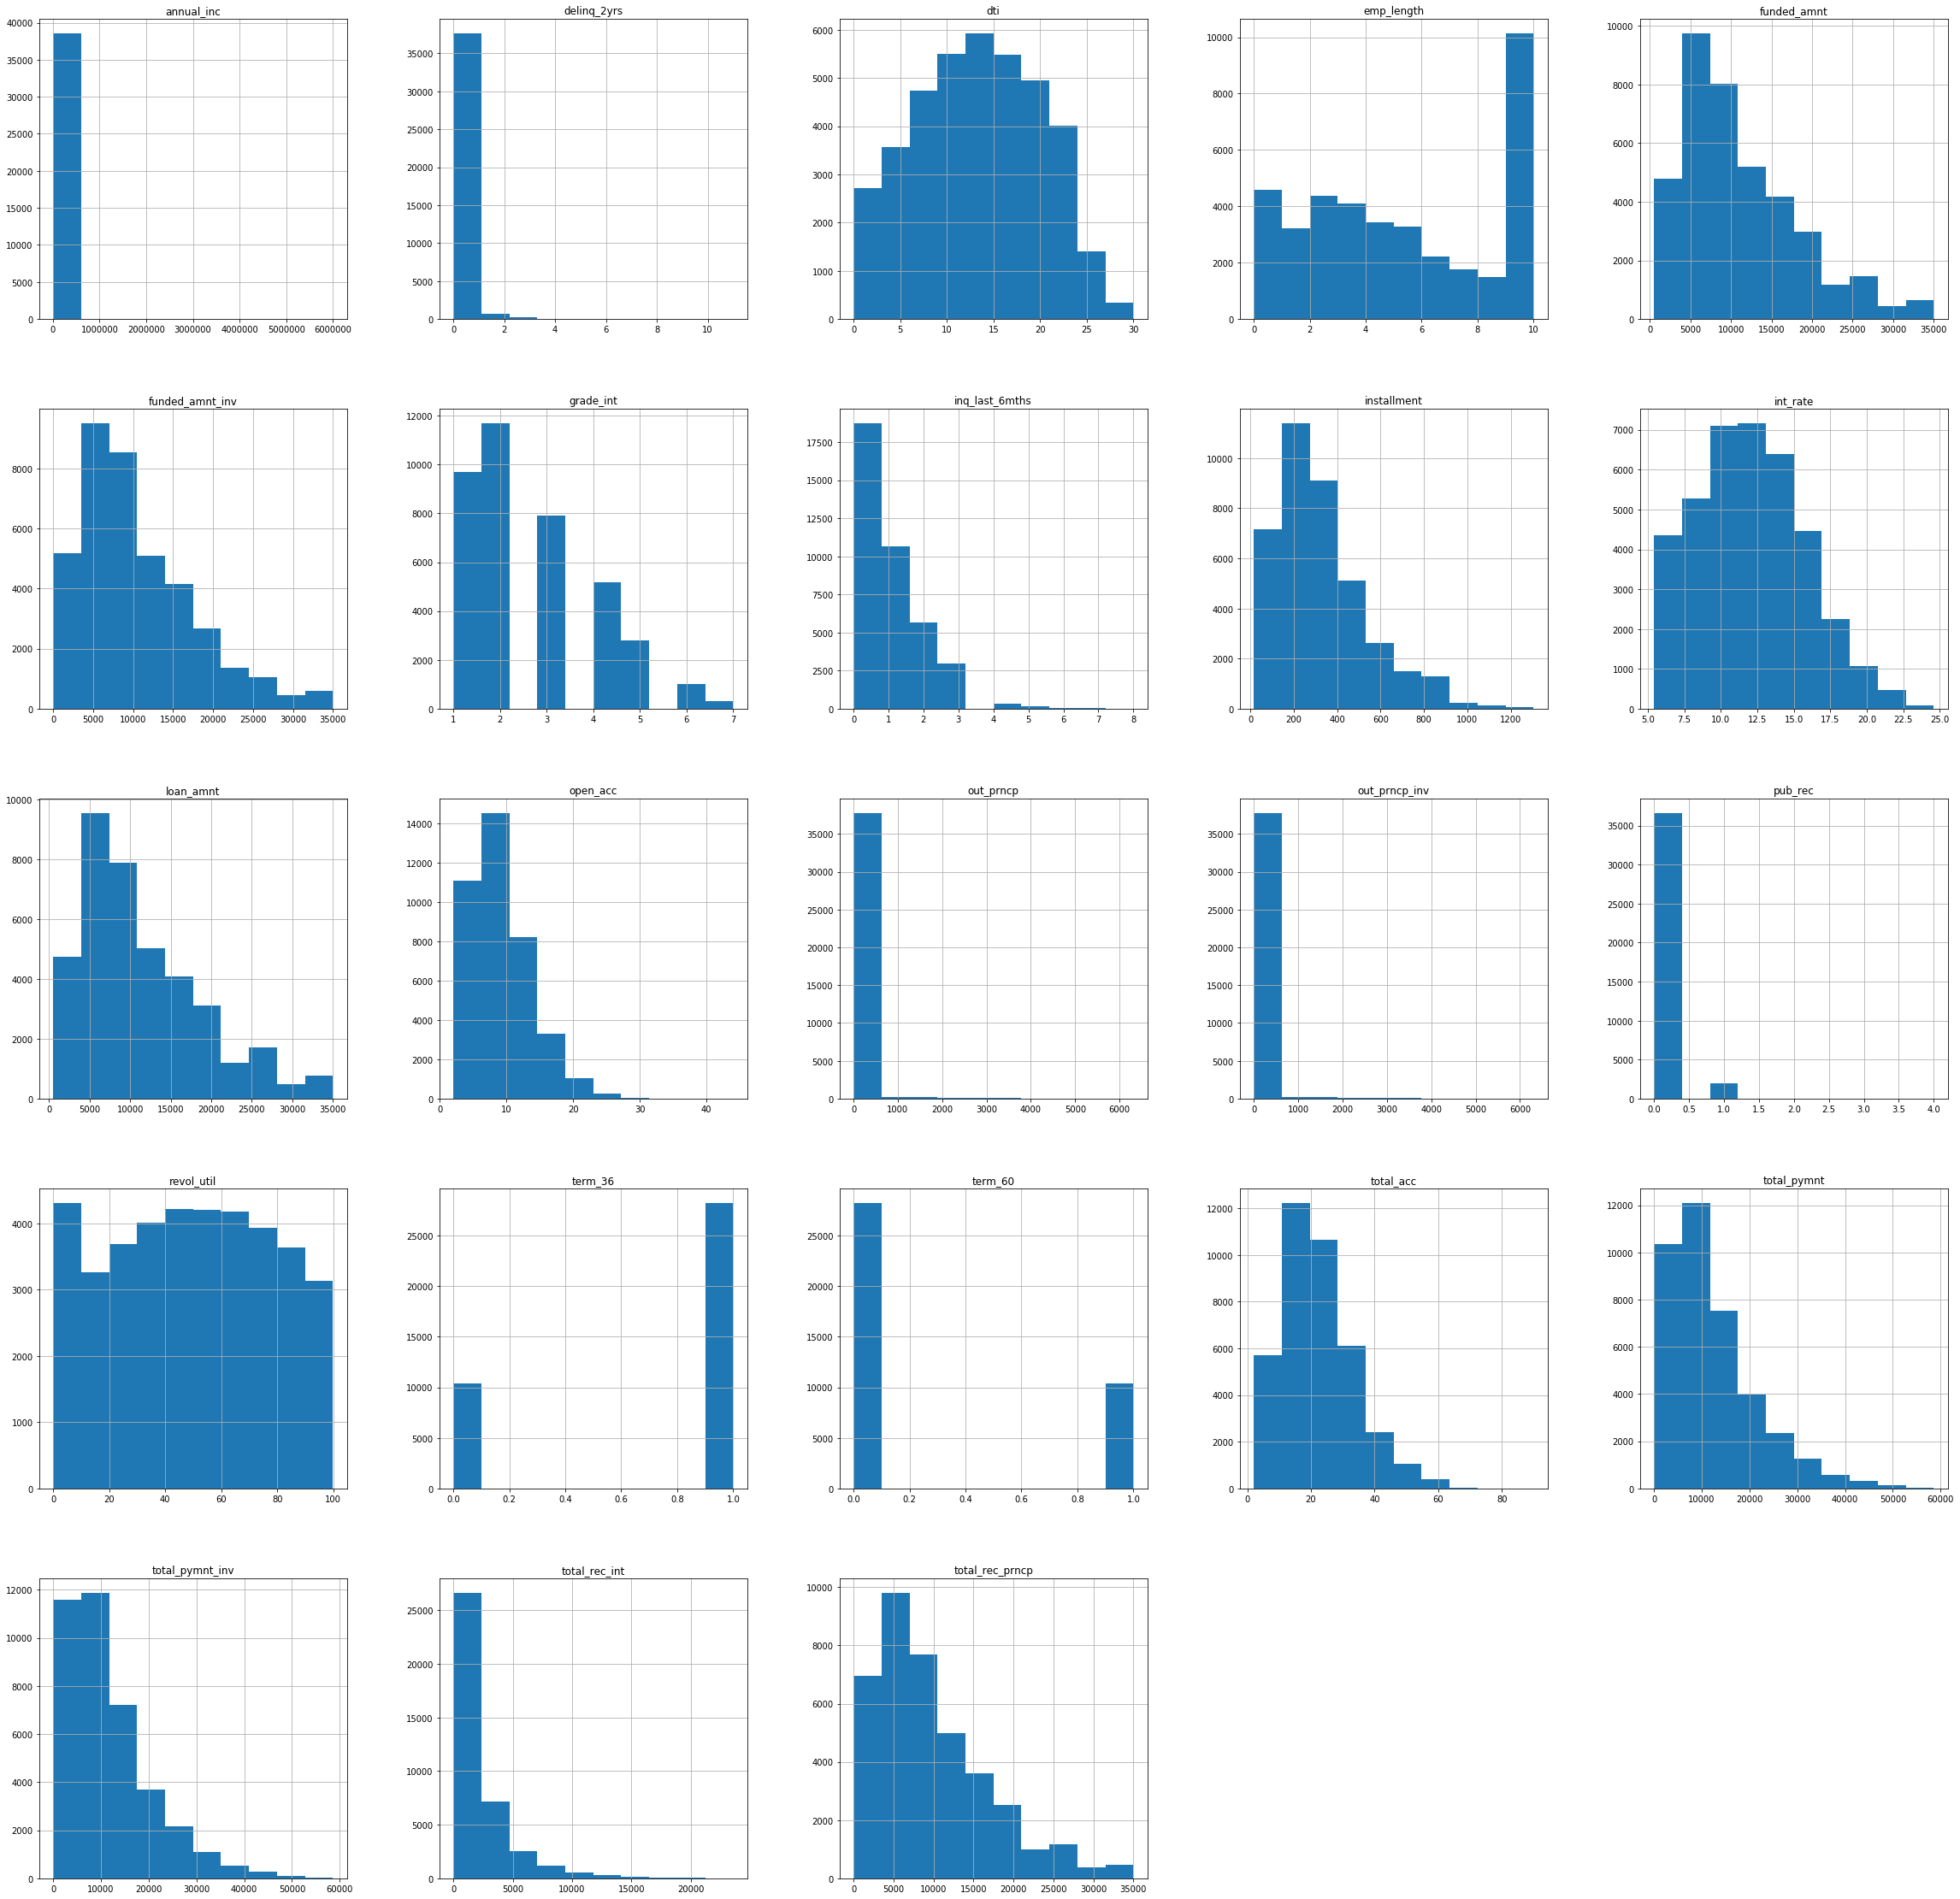

In [26]:
#Histogram of all variables

loans.hist(figsize=(40, 40))

Log-log plot for column : grade


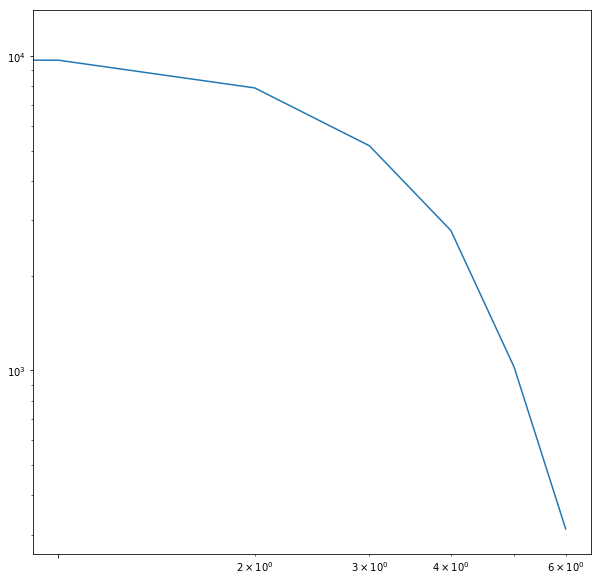

Log-log plot for column : sub_grade


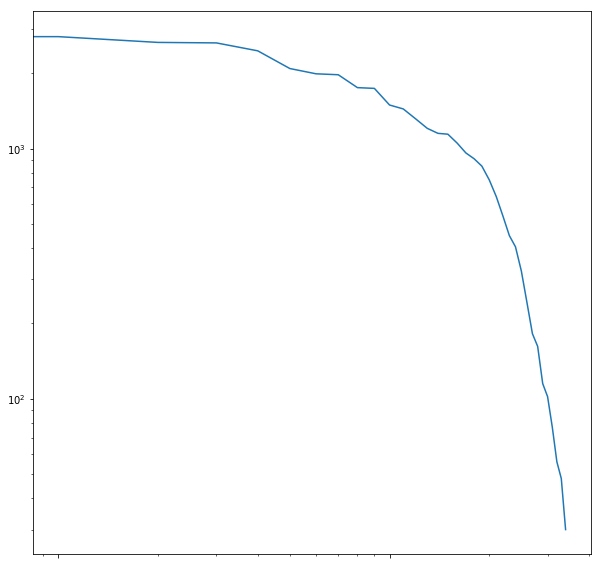

Log-log plot for column : home_ownership


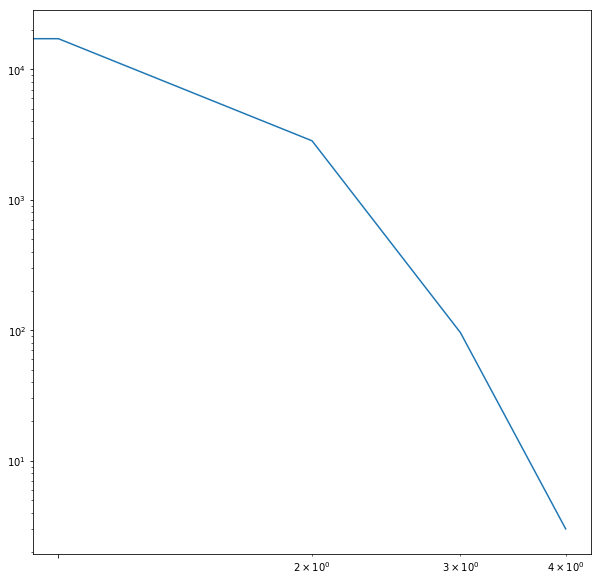

Log-log plot for column : verification_status


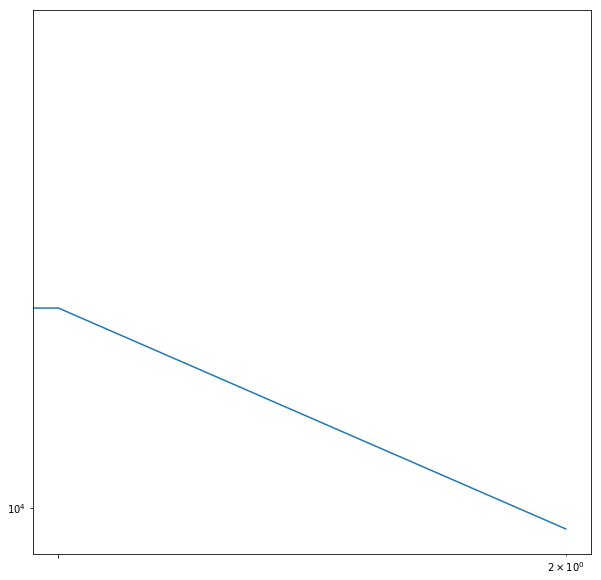

Log-log plot for column : loan_status


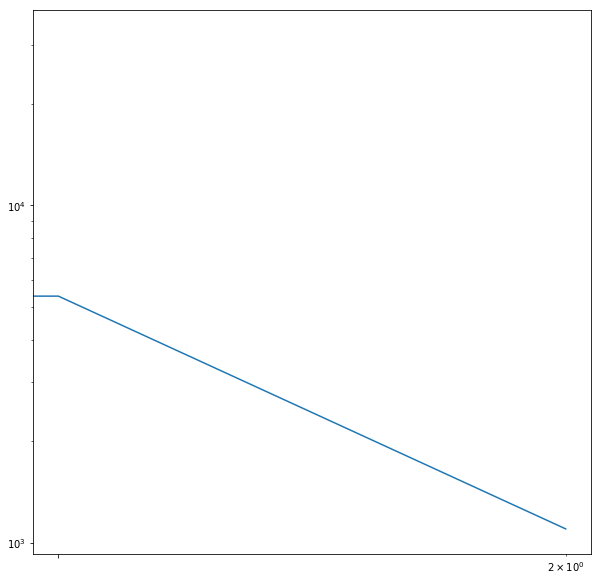

Log-log plot for column : purpose


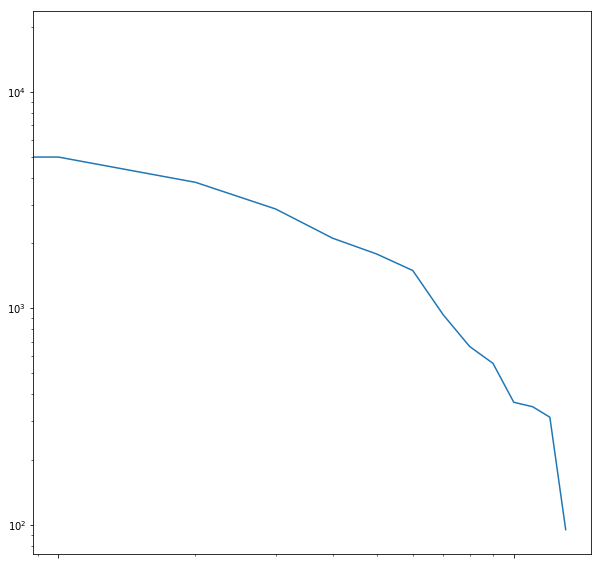

Log-log plot for column : addr_state


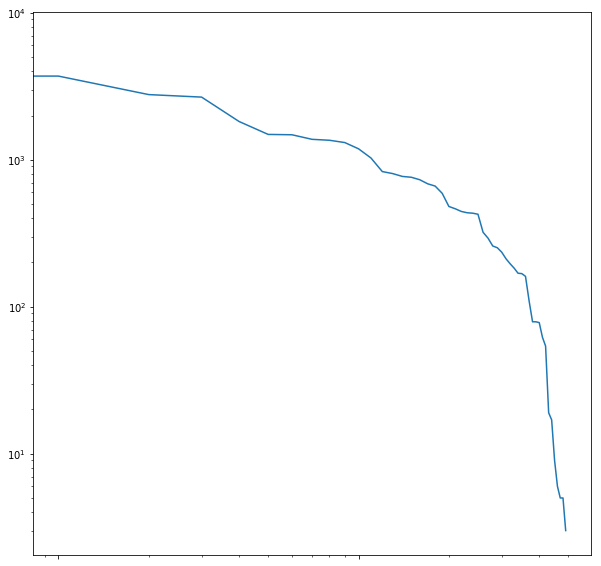

Log-log plot for column : addr_state_zip


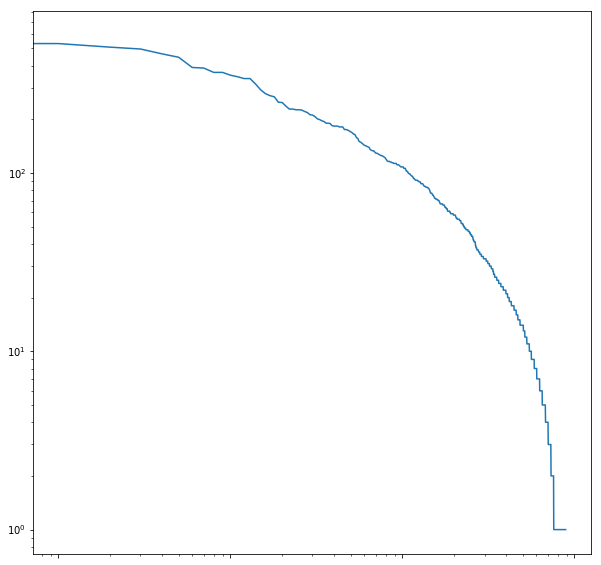

In [27]:
#Log-logs for categorical variables

cat_cols = loans.select_dtypes(include=['object'])

for col in cat_cols.columns:
    print ("Log-log plot for column : " + col)
    loans[col].value_counts().plot(loglog=True, legend=False, figsize=(10, 10))
    plt.show()

In [28]:
loans_df = loans

#### Remove columns that are extremely correlated from each other

In [30]:
threshold = 0.98
# Create correlation matrix
corr_matrix = loans_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.98
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

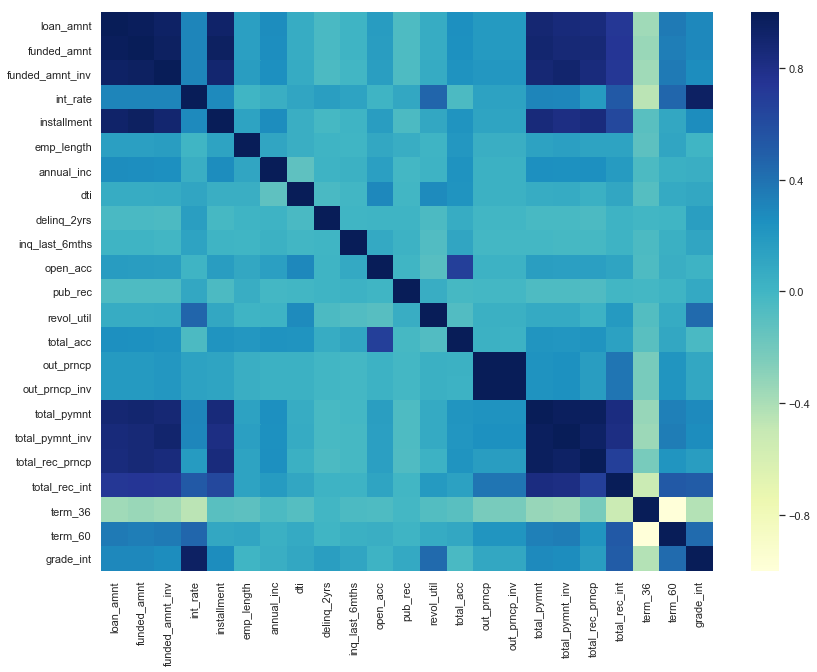

In [31]:
#Correlation heatmap
sns.set(rc={'figure.figsize':(13.7,10.27)})
sns.heatmap(loans_df.corr(), vmax=1., square=False , cmap="YlGnBu")
plt.show()

In [32]:
##Redundant columns 'funded_amnt', 'out_prncp_inv' since they are very
##highly correlated with 'loan_amnt, out_prncp
loans_df = loans_df.drop(to_drop, axis=1)

In [33]:
#Final loan_df shape
print(loans_df.shape)

(38595, 28)


In [34]:
loans_df.columns


Index(['loan_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'loan_status', 'purpose', 'addr_state', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util',
       'total_acc', 'out_prncp', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'term_36', 'addr_state_zip',
       'grade_int'],
      dtype='object')

In [38]:
loans_df.isna().any().sum()
#0
#Moving on

0

In [39]:

west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']



loans_df['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'
    

loans_df['region'] = loans_df.addr_state.apply(finding_regions)

### Attribute Analysis

#### Loan Amount and Funded amount

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Amount Funded')

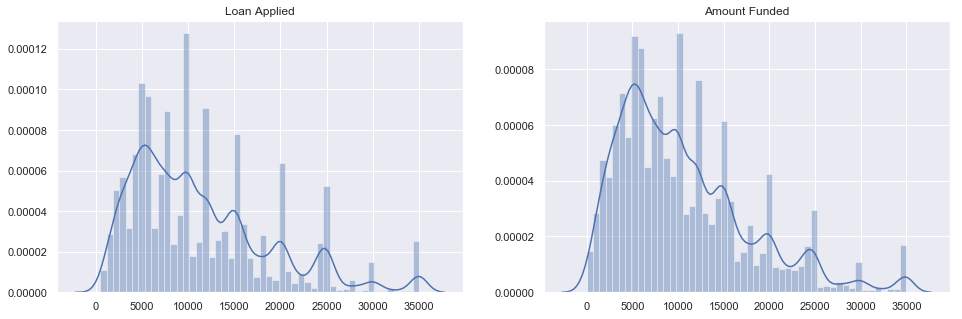

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))

loan_amount = loans_df["loan_amnt"].values
funded_amount = loans_df["funded_amnt_inv"].values


sns.distplot(loan_amount, ax=ax[0])
ax[0].set_title("Loan Applied", fontsize=12)
sns.distplot(funded_amount, ax=ax[1])
ax[1].set_title("Amount Funded", fontsize=12)

#### Grade and sub-grade

Text(0.5, 1.0, 'Type of Loans by Sub-Grade')

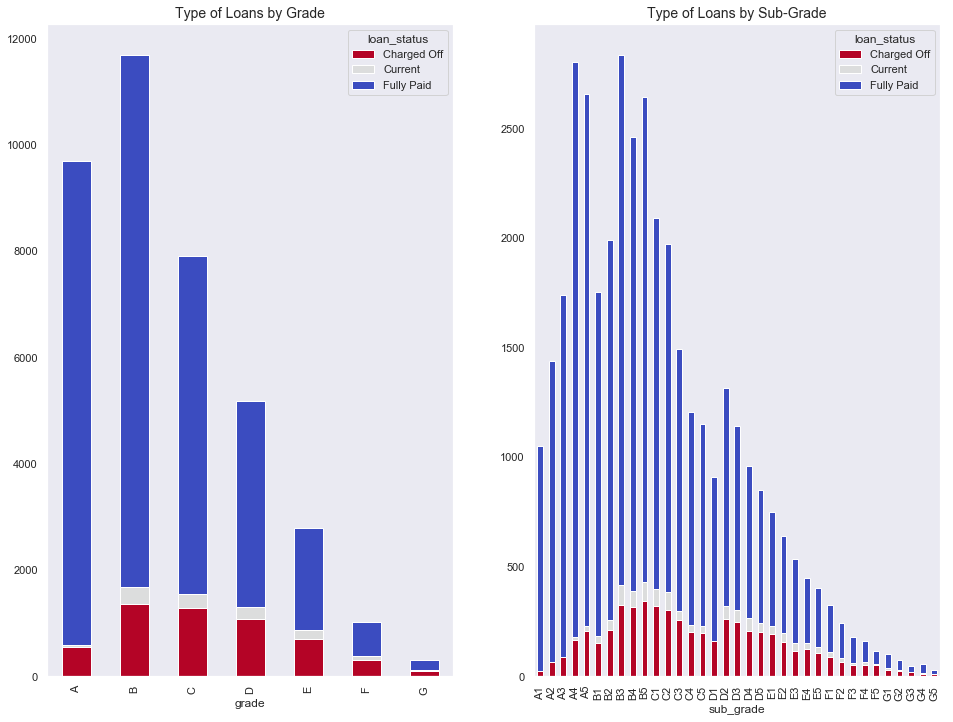

In [41]:
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

cmap = plt.cm.coolwarm_r

loans_by_region = loans_df.groupby(['grade', 'loan_status']).size()
loans_by_region.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax1, grid=False)
ax1.set_title('Type of Loans by Grade', fontsize=14)


loans_by_grade = loans_df.groupby(['sub_grade', 'loan_status']).size()
loans_by_grade.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax2, grid=False)
ax2.set_title('Type of Loans by Sub-Grade', fontsize=14)


#### Location

In [42]:
# loan_status per Region.
loan_status_cross = pd.crosstab(loans_df['addr_state'], loans_df['loan_status']).apply(lambda x: x/x.sum() * 100)
number_of_loanstatus = pd.crosstab(loans_df['addr_state'], loans_df['loan_status'])
number_of_loanstatus['Total'] = number_of_loanstatus.sum(axis=1)
number_of_loanstatus

loan_status,Charged Off,Current,Fully Paid,Total
addr_state,,,,
AK,15,2,61,78
AL,50,16,367,433
AR,26,9,200,235
AZ,113,28,690,831
CA,1073,143,5688,6904
CO,91,26,653,770
CT,89,24,618,731
DC,15,3,194,212
DE,11,1,98,110


#### Interest Rate

In [43]:
#Checking for interest rate. Does it remain similar, or if it has high variance.
#Higher interest rate loans might be difficult to pay off.
loans_df.int_rate.head()

0    10.65
1    15.27
2    15.96
3    13.49
4    12.69
Name: int_rate, dtype: float64

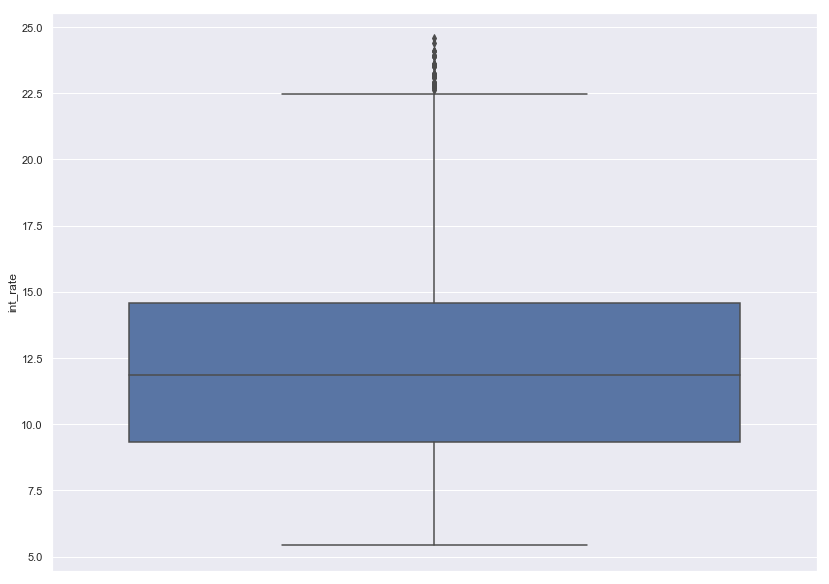

In [46]:
ax = sns.boxplot(y=loans_df.int_rate)

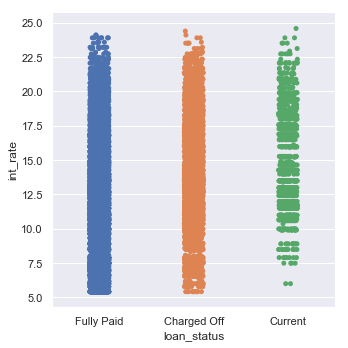

In [47]:
#It is clear that while most interest rates are between 9 and 14, there is a huge variance. Hence this can be a interesting parameter for analyisis
#Checking against loan_default_status
sns.catplot(x="loan_status", y="int_rate", data=loans_df);

In [48]:
#However, from the scatter plot we cannot say if interest rate is very affective to find if loan will default

#### Purpose

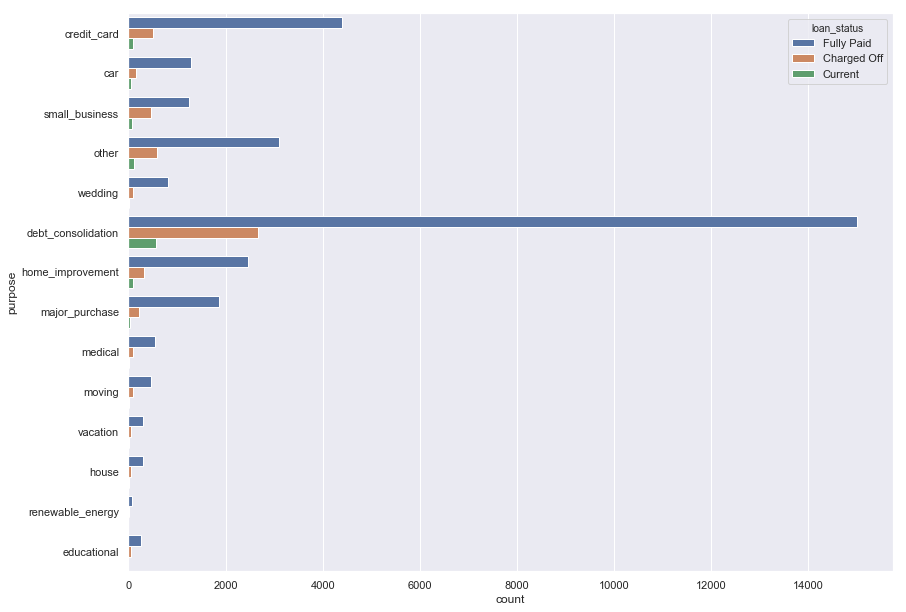

In [49]:
#Since this is a text column. Checking categories via a histplot
ax = sns.countplot(y="purpose", hue="loan_status", data=loans_df)

In [58]:
#Plotting Percentage of default loans (default/ default+fully paid) for each purpose
loans_purpose_df = loans_df[['id','purpose','loan_status']]
loans_purpose_pivot_df =loans_df.pivot_table(index=['purpose'],columns='loan_status', values='id',aggfunc='count',fill_value=0)
loans_purpose_pivot_df['default_ratio_loanscompleted%'] = (loans_purpose_pivot_df['Charged Off']/(loans_purpose_pivot_df['Fully Paid']+ loans_purpose_pivot_df['Charged Off']))*100
loans_purpose_pivot_df.sort_values(by='default_ratio_loanscompleted%', inplace=True, ascending=False)


KeyError: 'Charged Off'

In [55]:
loans_purpose_pivot_df.head()
#loans_purpose_pivot_df.purpose.head()
ax = sns.barplot(y=loans_purpose_pivot_df.index, x="default_ratio_loanscompleted%", data=loans_purpose_pivot_df)


ValueError: Could not interpret input 'default_ratio_loanscompleted%'

#### Ordinal Variable Analysis

In [56]:
#print(loans_df.columns)
for col in loans_df.columns:
    uniques = len(loans_df[col].unique())
    if uniques < 40:
        print(col,':',uniques,":", loans_df[col].unique())

grade : 7 : ['B' 'C' 'A' 'E' 'F' 'D' 'G']
sub_grade : 35 : ['B2' 'C4' 'C5' 'C1' 'B5' 'A4' 'E1' 'F2' 'C3' 'B1' 'D1' 'A1' 'B3' 'B4'
 'C2' 'D2' 'A3' 'A5' 'D5' 'A2' 'E4' 'D3' 'D4' 'F3' 'E3' 'F4' 'F1' 'E5'
 'G4' 'E2' 'G3' 'G2' 'G1' 'F5' 'G5']
emp_length : 11 : [10.  0.  1.  3.  8.  9.  4.  5.  6.  2.  7.]
home_ownership : 5 : ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE']
verification_status : 3 : ['Verified' 'Source Verified' 'Not Verified']
loan_status : 3 : ['Fully Paid' 'Charged Off' 'Current']
purpose : 14 : ['credit_card' 'car' 'small_business' 'other' 'wedding'
 'debt_consolidation' 'home_improvement' 'major_purchase' 'medical'
 'moving' 'vacation' 'house' 'renewable_energy' 'educational']
delinq_2yrs : 11 : [ 0  2  3  1  4  6  5  8  7  9 11]
inq_last_6mths : 9 : [1 5 2 0 3 4 6 7 8]
pub_rec : 5 : [0 1 2 3 4]
term_36 : 2 : [1 0]
grade_int : 7 : [2 3 1 5 6 4 7]
region : 5 : ['SouthWest' 'SouthEast' 'MidWest' 'West' 'NorthEast']


In [57]:
#Similar analysis for all ordinal variables
ordinal_variables = ['term','purpose', 'region','addr_state','grade','sub_grade','home_ownership','verification_status']
loans_ordinal_pivot_df_arr = {}
min_loans = 5
for ordinal in ordinal_variables:
    loans_ordinal_df = loans_df[['id',ordinal,'loan_status']]
    loans_ordinal_pivot_df =loans_df.pivot_table(index=ordinal,columns='loan_status', values='id',aggfunc='count',fill_value=0)
    loans_ordinal_pivot_df['default_ratio_loanscompleted%'] = (loans_ordinal_pivot_df['Charged Off']/(loans_ordinal_pivot_df['Fully Paid']+ loans_ordinal_pivot_df['Charged Off']))*100
    loans_ordinal_pivot_df.sort_values(by='default_ratio_loanscompleted%', inplace=True, ascending=False)
    loans_ordinal_pivot_df = loans_ordinal_pivot_df.loc[loans_ordinal_pivot_df['Charged Off']+loans_ordinal_pivot_df['Fully Paid']>min_loans]
    loans_ordinal_pivot_df_arr[ordinal]= loans_ordinal_pivot_df
#Percentage of loans in each category

KeyError: "['id' 'term'] not in index"

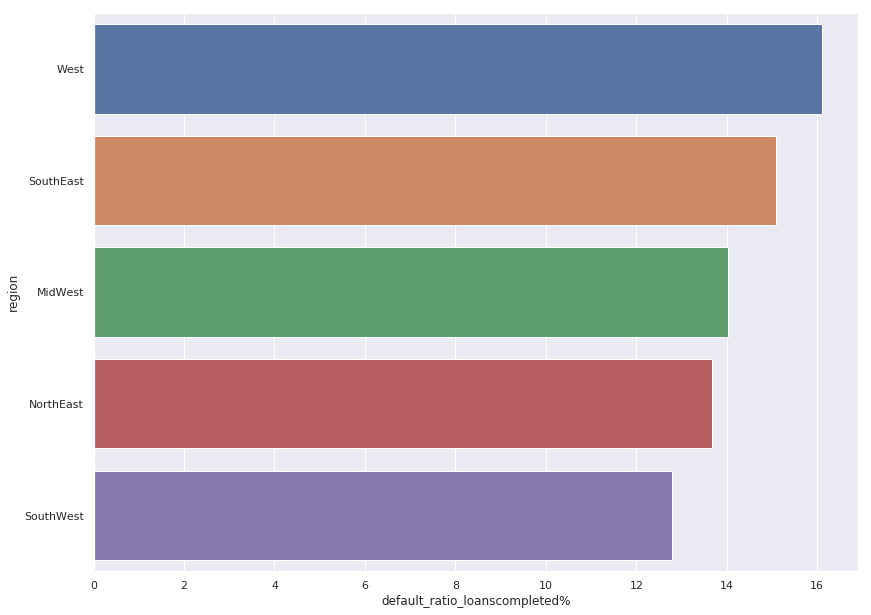

In [33]:
df_to_use =loans_ordinal_pivot_df_arr['region'].head(20)
ax = sns.barplot(y=df_to_use.index, x="default_ratio_loanscompleted%", data=df_to_use)

### Interval Variable Analysis

In [34]:
annual_inc, emp_length,
pub_rec,
pub_rec_bankruptcies,
inq_last_6mths
#No idea how to treat desc

NameError: name 'annual_inc' is not defined

In [35]:
loans_df.columns

Index(['id', 'loan_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment',
       'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'title', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'total_acc', 'out_prncp', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'pub_rec_bankruptcies', 'addr_state_zip', 'region'],
      dtype='object')

## Multivariate

In [36]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [43]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = loans_df.select_dtypes(include=numerics)

In [47]:
std_df = scale(newdf)
std_df = pd.DataFrame(std_df, index=newdf.index, columns=newdf.columns)

/home/nautiyogi/anaconda3/envs/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


In [49]:
std_df.apply(np.mean)

id                      9.159752e-17
loan_amnt              -4.579876e-17
funded_amnt_inv         0.000000e+00
int_rate                5.782094e-16
installment             1.803326e-16
emp_length              5.724845e-18
annual_inc             -5.116580e-17
dti                     5.209609e-16
delinq_2yrs             2.576180e-17
inq_last_6mths         -3.721149e-17
open_acc                1.270200e-16
pub_rec                -7.156056e-18
revol_bal               5.009240e-18
total_acc              -2.576180e-17
out_prncp              -1.717454e-17
total_pymnt             1.717454e-16
total_pymnt_inv        -1.946447e-16
total_rec_prncp        -1.316714e-16
total_rec_int          -1.259466e-16
total_rec_late_fee      4.579876e-17
pub_rec_bankruptcies   -5.009240e-17
dtype: float64

In [50]:
std_df.apply(np.std)

id                      1.0
loan_amnt               1.0
funded_amnt_inv         1.0
int_rate                1.0
installment             1.0
emp_length              1.0
annual_inc              1.0
dti                     1.0
delinq_2yrs             1.0
inq_last_6mths          1.0
open_acc                1.0
pub_rec                 1.0
revol_bal               1.0
total_acc               1.0
out_prncp               1.0
total_pymnt             1.0
total_pymnt_inv         1.0
total_rec_prncp         1.0
total_rec_int           1.0
total_rec_late_fee      1.0
pub_rec_bankruptcies    1.0
dtype: float64

In [51]:
pca = PCA().fit(std_df)

In [52]:
def pca_summary(pca, standardised_data, out=True):
    names = ["PC"+str(i) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    a = list(np.std(pca.transform(standardised_data), axis=0))
    b = list(pca.explained_variance_ratio_)
    c = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    columns = pd.MultiIndex.from_tuples([("sdev", "Standard deviation"), ("varprop", "Proportion of Variance"), ("cumprop", "Cumulative Proportion")])
    summary = pd.DataFrame(zip(a, b, c), index=names, columns=columns)
    if out:
        print("Importance of components:")
        display(summary)
    return summary
summary = pca_summary(pca, std_df)

Importance of components:


,sdev,varprop,cumprop
,Standard deviation,Proportion of Variance,Cumulative Proportion
PC1,2.593289,0.320245,0.320245
PC2,1.395294,0.092707,0.412952
PC3,1.372803,0.089742,0.502694
PC4,1.140314,0.061920,0.564614
PC5,1.109337,0.058601,0.623215
PC6,1.041089,0.051613,0.674828
PC7,0.992730,0.046929,0.721757
PC8,0.984371,0.046142,0.767899
PC9,0.953883,0.043328,0.811228


In [53]:
summary.sdev

,Standard deviation
PC1,2.593289
PC2,1.395294
PC3,1.372803
PC4,1.140314
PC5,1.109337
PC6,1.041089
PC7,0.992730
PC8,0.984371
PC9,0.953883
PC10,0.933394


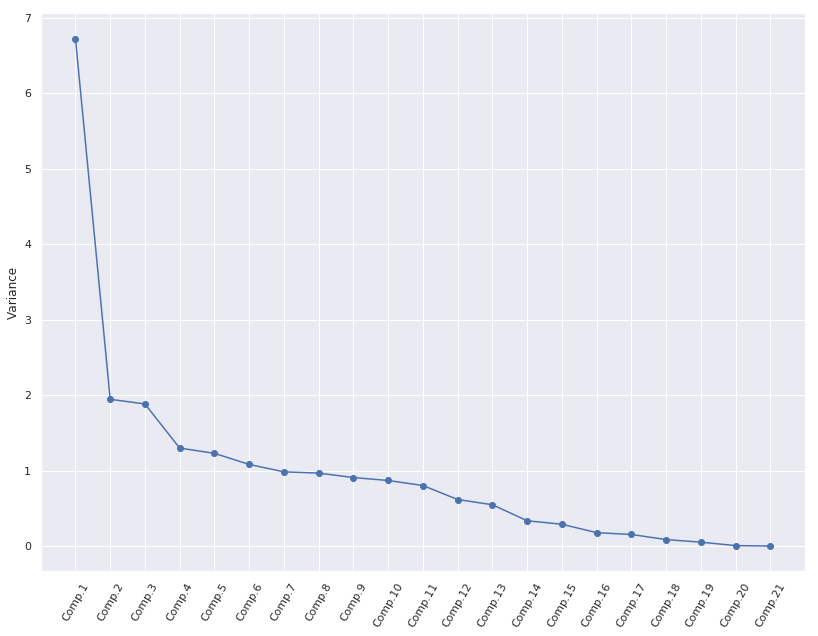

In [54]:
def  screeplot(pca, standardised_values):
    y = np.std(pca.transform(standardised_values), axis=0)**2
    x = np.arange(len(y)) + 1
    plt.plot(x, y, "o-")
    plt.xticks(x, ["Comp."+str(i) for i in x], rotation=60)
    plt.ylabel("Variance")
    plt.show()

screeplot(pca, std_df)

In [57]:
#the weights
pca.components_.shape

(21, 21)